<center>
 <img src = "https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png">
 </center>
 
# Warming up with JAX
In this notebook a basic introduction to JAX is given. For more resources including papers, blog posts, tutorial, and documentation refer to [awsome-JAX repo](https://github.com/n2cholas/awesome-jax#tutorials-and-blog-posts).
<br>
<br>

## Motivation
Python frameworks has dominated the world of machine learning and deep learning by providing user friendly high-level libraries. Such as numpy, sklearn, pytorch, and tensorflow.[\[ 2 \]](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
<br>
<br>

While these libraries are suitable to general users, python being an interpretable dynamic language and numpy being only designed for cpu make them inadequate for the research community.

JAX, hence, is aiming to solve the following shortcomming in the current ML/DL echosystem:

* Accelerator agnostic library
* Auto Defferentiation support
* Optimizing operations
* Speed-up by micro-operation optimization
* Easy vectorization
* Reproducable multi-accelerator training(RNG)
<br>
<br>

## Introduction
 * JAX is a python machine learning framework developed in Google Research Team [\[1\]](https://www.deepmind.com/blog/using-jax-to-accelerate-our-research)
 * JAX API was designed based on Numpy --> easy to employ
 * JAX includes an extensible system of composable function transformations that help support machine learning research:
 
$\qquad$ 1. Differentiation

$\qquad$ 2. Vectorisation

$\qquad$ 3. JIT-compilation(speed up)


## import libs/pkgs

In [ ]:
# JAX's syntax is (for the most part) same as NumPy's!
# There is also a SciPy API support (jax.scipy)
import jax.numpy as jnp
import numpy as np

# Special transform functions (we'll understand what these are very soon!)
from jax import grad, jit, vmap, pmap

# JAX's low level API 
# (lax is just an anagram for XLA
from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

## Consistent API with np 
Jax and numpy pretty much follow the same API syntax

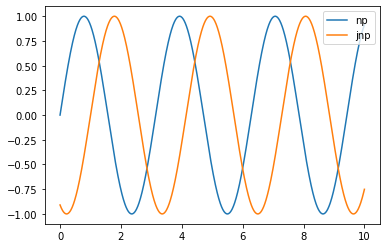

In [ ]:
# np version
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)

# JAX version
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp-1) * jnp.cos(x_jnp-1)

# plot
plt.plot(x_np, y_np, label="np")
plt.plot(x_jnp, y_jnp, label="jnp")
plt.legend()

## In-place operations
JAX arrays are immutable! (embrace the functional programming paradigm.

NP arrays are, however, mutable in default setting.

In [ ]:
size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(f"original  np array: {x}")
x[index] = value
print(f"modified  np array: {x}")

# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(f"original jnp array: {x}")
try:
  x[index] = value #!! exception
  print(f"modified jnp array: {x}")
except:
  print("Exception for immutable object assignment")

original  np array: [0 1 2 3 4 5 6 7 8 9]
modified  np array: [23  1  2  3  4  5  6  7  8  9]
original jnp array: [0 1 2 3 4 5 6 7 8 9]
Exception for immutable object assignment


Allowing mutation of variables in-place makes program analysis and transformation difficult.
<br><br>
There is a inderect way of modifying elements of jnp array via the .at and .set methods
<br><br>
JAX’s array update functions, unlike their NumPy versions, operate out-of-place. That is, the updated array is returned as a new array and the original array is not modified by the update.
<br><br>
However, inside jit-compiled code, if the input value x of x.at[idx].set(y) is not reused, the compiler will optimize the array update to occur in-place.

In [ ]:
# Solution/workaround:
x = jnp.arange(size)
print(f"original jnp array: {x}")
try:
  y = x.at[index].set(value)
  print(f"modified jnp array: {y}")
except:
  print("Exception for immutable object assignment")

original jnp array: [0 1 2 3 4 5 6 7 8 9]
modified jnp array: [23  1  2  3  4  5  6  7  8  9]


## Random Generation

The commonway to make a model reproducable is to set a seed for numpy.global RNG.

This is done by executing 

```
SEED = #YOURSEDD
np.random.seed(SEED)
```
This approach does not work as in a parallel computing framework setting a global seed does not guarantee reproducability. For more information refer to [this blog post](https://albertcthomas.github.io/good-practices-random-number-generators/).
<br><br>

JAX handles random numbers differently becuase rng of np has stateful seed making it inpractical for distributed reproducability.

In [ ]:
# How to work with random generation in JAX
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(f"{type(x)} \n {x}")  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib.xla_extension.DeviceArray'> 
 [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


## Accelerator agnostic data structures

Had you worked with any DL frame work, the term .to(device) should not be a suprise for you. This points out that the current DL frame works do not automatically place the data on the accelerator, and hece the developrs should do it manually. 

In [ ]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!
size = 1000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

The slowest run took 1905.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.18 ms per loop
100 loops, best of 5: 16 ms per loop
The slowest run took 6.04 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 1.96 ms per loop
1000 loops, best of 5: 763 µs per loop


## Jit()

* `jit` compiles your functions using XLA and caches them -> speed up 

In [ ]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = jnp.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

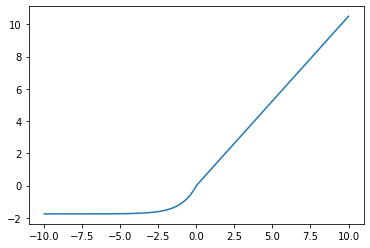

non-jit version:
The slowest run took 158.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 2.75 ms per loop
jit version:
The slowest run took 236.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 513 µs per loop


In [ ]:
# Define a function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)  # let's jit it

# Visualize SELU (just for your understanding, it's always a good idea to visualize stuff)
visualize_fn(selu)

# Benchmark non-jit vs jit version
data = random.normal(key, (10000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

# Note: we'll soon see how this works (hint: jaxpr, pure functions)

## grad()

Differentation can be:
* manual -> hard for implementing complex functions
* symbolic -> intracble for large number of parameters (NNs)
* numeric -> always inaccurate
* automatic -> simple PERFECT (backpropegation)

In [ ]:
# First example (automatic diff)
def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(type(grad_loss)) # it is a function itself
print(grad_loss(x))


<class 'function'>
[0.25       0.19661194 0.10499357]


In [ ]:
# Numeric diff (to double check that autodiff works correctly)
def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.24998187 0.1965761  0.10502338]


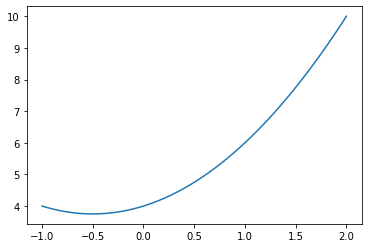

f(x) = 6.0, dfdx(x) = 3.0, d2fdx(x) = 2.0, d3fdx(x) = 0.0


In [ ]:
# Second example (automatic diff)

x = 1.  # example input

f = lambda x: jnp.power(x, 2) + x + 4  # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

print(f"f(x) = {f(x)}, dfdx(x) = {dfdx(x)}, d2fdx(x) = {d2fdx(x)}, d3fdx(x) = {d3fdx(x)}")

### Hessian-vector products with `grad`-of-`grad`

One thing we can do with higher-order `grad` is build a Hessian-vector product function. (Later on we'll write an even more efficient implementation that mixes both forward- and reverse-mode, but this one will use pure reverse-mode.)

A Hessian-vector product function can be useful in a [truncated Newton Conjugate-Gradient algorithm](https://en.wikipedia.org/wiki/Truncated_Newton_method) for minimizing smooth convex functions, or for studying the curvature of neural network training objectives (e.g. [1](https://arxiv.org/abs/1406.2572), [2](https://arxiv.org/abs/1811.07062), [3](https://arxiv.org/abs/1706.04454), [4](https://arxiv.org/abs/1802.03451)).

For a scalar-valued function $f : \mathbb{R}^n \to \mathbb{R}$ with continuous second derivatives (so that the Hessian matrix is symmetric), the Hessian at a point $x \in \mathbb{R}^n$ is written as $\partial^2 f(x)$. A Hessian-vector product function is then able to evaluate

$\qquad v \mapsto \partial^2 f(x) \cdot v$

for any $v \in \mathbb{R}^n$.

The trick is not to instantiate the full Hessian matrix: if $n$ is large, perhaps in the millions or billions in the context of neural networks, then that might be impossible to store.

Luckily, `grad` already gives us a way to write an efficient Hessian-vector product function. We just have to use the identity

$\qquad \partial^2 f (x) v = \partial [x \mapsto \partial f(x) \cdot v] = \partial g(x)$,

where $g(x) = \partial f(x) \cdot v$ is a new scalar-valued function that dots the gradient of $f$ at $x$ with the vector $v$. Notice that we're only ever differentiating scalar-valued functions of vector-valued arguments, which is exactly where we know `grad` is efficient.

In JAX code, we can just write this:

In [ ]:
def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

In [ ]:
# JAX autodiff engine is very powerful ("advanced" example)
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hessian = ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


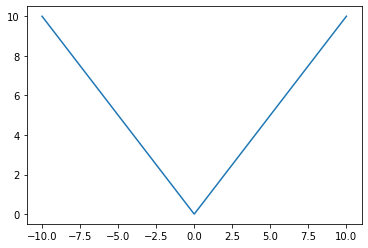

f(-1)=1, f(+1)=1
1.0


In [ ]:
# Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

print(f"f(-1)={f(-1)}, f(+1)={f(1)}")
dfdx = grad(f)
print(dfdx(0.))  # play with numbers around 0 and see how JAX handles it

## vmap()

* Write your functions as if you were dealing with a single datapoint!

In [ ]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

In [ ]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
The slowest run took 90.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.09 ms per loop


In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 641.57 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 96.5 µs per loop


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 1077.82 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 50 µs per loop


## JAX API structure

* NumPy <-> lax <-> XLA
* lax API is stricter and more powerful
* It's a Python wrapper around XLA 

In [ ]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion

2.0


TypeError: ignored

In [ ]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1E-6)

# XLA: https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


## How does JIT actually work?

In [ ]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

1000 loops, best of 5: 445 µs per loop
1000 loops, best of 5: 217 µs per loop


In [ ]:
# Example of a failure: array shapes must be static

def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [ ]:
print(jit(get_negatives)(x))

NonConcreteBooleanIndexError: ignored

In [ ]:
# So how does it work in the background? -> tracing on different levels of abstraction

@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
[-0.56435525 -0.46680963  9.840428  ]
Second call:
[ 0.3181104  -0.20914805  1.019433  ]


Final conclusions, TL;DR:
* Excellent for researchers (very powerful, device agnostic code, etc.)
* Definitely way too complicated for beginners (functional paradigm, optimization details, etc.) compared to PyTorch

In the next video we'll go mid to high levels of abstraction introducing concepts such as PyTree, handling state (as that's a natural way to handle NNs) in a functional paradigm, etc.